In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so

## Procesamiento de datos

In [3]:
ruta_datasets = 'data/'

In [4]:
dataset_sube = pd.read_csv(ruta_datasets+'sube-2023.csv')
dataset_sube_regresion = pd.read_csv(ruta_datasets+'sube-2023-regresion.csv')

### Ejercicio 1

#### a)

Describimos el dataset

In [183]:
dataset_sube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


Transformamos la columna dia_transporte a datetime

In [5]:
dataset_sube['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube['DIA_TRANSPORTE'], format='%Y-%m-%d')

#### b)

##### i.

Creamos la columna fecha_dia con el nombre del día de la semana

In [6]:
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
def obtener_nombre_dia(fecha_dia):
    return dias[fecha_dia.weekday()]

In [7]:
dataset_sube['FECHA_DIA'] = dataset_sube['DIA_TRANSPORTE'].apply(obtener_nombre_dia)

##### ii.

Creamos la columna fecha_ordinal donde asignamos el numero de día del año a cada fecha

In [8]:
dataset_sube['FECHA_ORDINAL'] = dataset_sube['DIA_TRANSPORTE'].dt.day_of_year

##### iii.

Creamos la columna fecha_mes con el numero de mes para cada fecha

In [9]:
dataset_sube['FECHA_MES'] = dataset_sube['DIA_TRANSPORTE'].dt.month

### Ejercicio 2

Creamos un dataframe que contiene solo los datos del AMBA y elimina los datos preliminares

In [189]:
datos_amba = dataset_sube[dataset_sube['AMBA']=='SI']
datos_amba = datos_amba[datos_amba['DATO_PRELIMINAR']=='NO']

Acomodamos el orden de las columnas y les corregimos el formato del nombre

In [190]:
datos_amba = datos_amba[['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL', 'JURISDICCION', 'LINEA','CANTIDAD', 'TIPO_TRANSPORTE']]

In [193]:
datos_amba = datos_amba.rename(columns={"DIA_TRANSPORTE": "fecha", "FECHA_DIA": "fecha_dia","FECHA_MES" : "fecha_mes", "FECHA_ORDINAL":"fecha_ordinal","JURISDICCION": "jurisdiccion", "LINEA":'linea',"CANTIDAD":"pasajeros", "TIPO_TRANSPORTE": "tipo_transporte"})

Resultado final:

In [194]:
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Domingo,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Domingo,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Domingo,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


### Ejercicio 3

#### a)

Calculamos la proporcion de pasajeros por transporte en 2023

In [195]:
pasajeros_totales = sum(datos_amba['pasajeros'])

In [196]:
pasajeros_por_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum()

In [197]:
## ponerlo mas lindo. Signo %
proporcion_pasajeros = (pasajeros_por_transporte/pasajeros_totales)*100 
proporcion_pasajeros.round(1)

tipo_transporte
COLECTIVO    83.8
SUBTE         6.8
TREN          9.4
Name: pasajeros, dtype: float64

#### b)

Creamos un dataset con los datos del Subte, agrupamos por mes y linea, y obtenemos el valor maximo

In [198]:
datos_subte = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']
datos_subte = datos_subte[['fecha_mes','linea','pasajeros']]

In [199]:
datos_subte_mesLinea = datos_subte.groupby(['fecha_mes','linea'])['pasajeros'].sum()

In [200]:
mes_linea_maxPasajeros = pd.DataFrame(datos_subte_mesLinea).idxmax()

Tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [201]:
mes_linea_maxPasajeros.iloc[0]

(8, 'LINEA_B')

#### c)

Creamos el dataset solo con los días habiles, calculamos el desvío estandar para cada día y vemos el menor

In [202]:
dias_habiles = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes']
datos_amba_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]

In [203]:
desvios = []
for dia_habil in dias_habiles:
    desvio_estandar = datos_amba_habiles[datos_amba_habiles['fecha_dia']==dia_habil]['pasajeros'].std().round(1)
    desvio_dia = (dia_habil, desvio_estandar)
    desvios.append(desvio_dia)
print(desvios)

[('Lunes', 33577.5), ('Martes', 35833.7), ('Miércoles', 35980.8), ('Jueves', 35968.3), ('Viernes', 35059.7)]


In [206]:
dia_menos_desvio = min(desvios, key=lambda x: x[1])
dia_menos_desvio[0]

'Lunes'

## Analisis exploratorio

### Ejercicio 4

- mediana, media, variacion, desvio estandar, promedio (.mean(), .std(), )
- cantidad de pasajeros por mes para cada transporte
- cantidad de pasajeros por provincia
- cantidad de pasajeros por año (sumar desde 2020)
- cantidad de pasajeros por municipio AMBA
- cantidad de pasajeros ?

In [261]:
dataset_sube[dataset_sube['CANTIDAD']<0]

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_ORDINAL,FECHA_MES
284929,2023-08-13,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-25,NO,Domingo,225,8
284930,2023-08-13,SOFSE- SARMIENTO,FFCC SAR MORENO - MERCEDES,SI,TREN,NACIONAL,JN,SD,-1,NO,Domingo,225,8
284933,2023-08-13,SOFSE - Belgrano Sur,FFCC_BELG_SUR,SI,TREN,NACIONAL,JN,SD,-11,NO,Domingo,225,8
378164,2023-10-22,SOFSE - Belgrano Sur,FFCC_BELG_SUR,SI,TREN,NACIONAL,JN,SD,-1,NO,Domingo,295,10
387623,2023-10-29,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-92,NO,Domingo,302,10
388788,2023-10-30,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-417,NO,Lunes,303,10


<Axes: xlabel='fecha_mes', ylabel='pasajeros'>

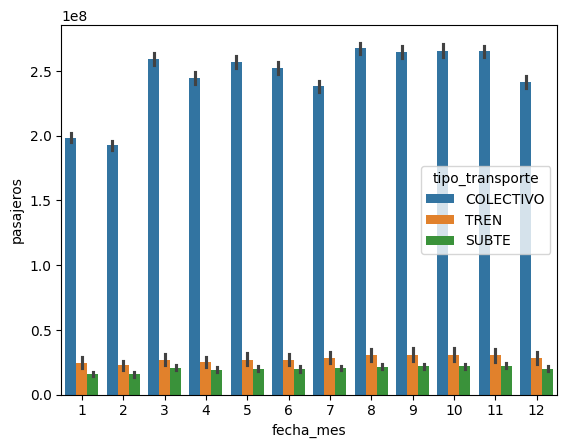

In [244]:
sns.barplot(data=datos_amba, x='fecha_mes', y='pasajeros', hue='tipo_transporte', estimator='sum')

<Axes: xlabel='fecha_mes', ylabel='pasajeros'>

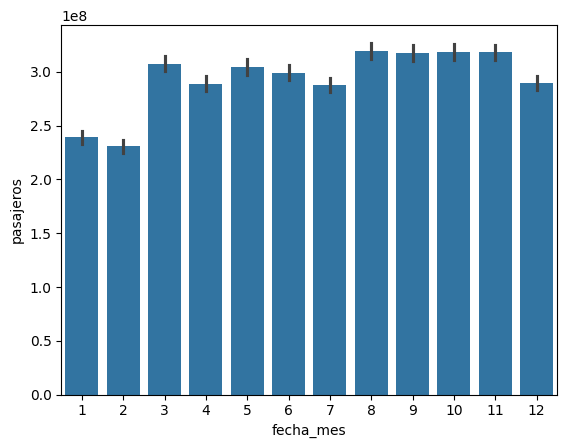

In [216]:
sns.barplot(data=datos_amba, x='fecha_mes', y='pasajeros', estimator='sum')

<Axes: xlabel='fecha_dia', ylabel='pasajeros'>

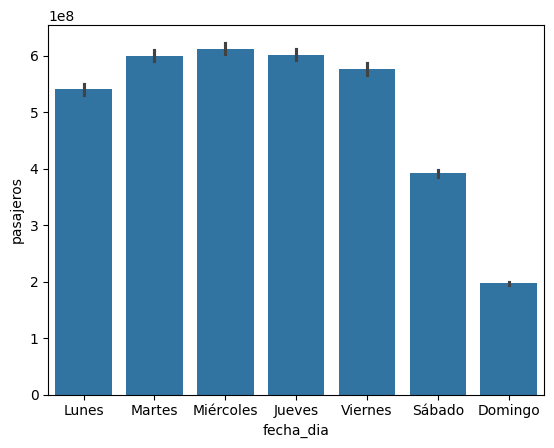

In [220]:
sns.barplot(data=datos_amba, x='fecha_dia', y='pasajeros', estimator='sum', order=dias)

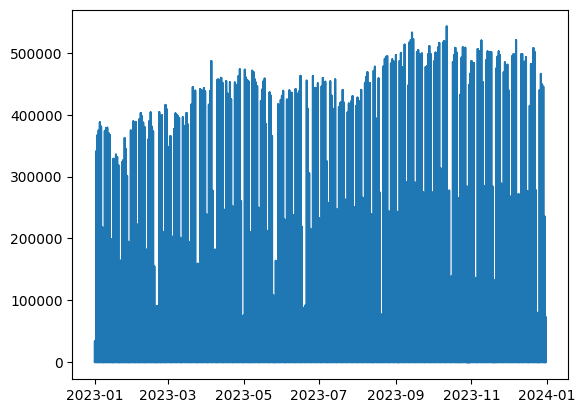

In [211]:
plt.plot(dataset_sube['DIA_TRANSPORTE'], dataset_sube['CANTIDAD'])

## Modelado

### Ejercicio 5